### 휴먼지능정보공학과 201910787 김영서

서울시 열린데이터 https://data.seoul.go.kr/ 에서 제공하는 ```서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv```를 분석해보자.

파일은 웹 검색을 하고 다운로드해서 사용하면 된다.<br>
데이터는 일자별로, 대여건수이이고, 몇 줄만 출력해보면 다음과 같다.

|      date| count|
|----------|------|
|2018-01-01|  4950|
|2018-01-02|  7136|
|2018-01-03|  7156|
|2018-01-04|  7102|
|2018-01-05|  7705|

In [1]:
import sys
import os

home=os.path.expanduser("~")
os.environ["PYSPARK_PYTHON"]="C:\\Users\\zaqxs\\Anaconda2\\envs\\py35\\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"]="C:\\Users\\zaqxs\\Anaconda2\\envs\\py35\\python.exe"
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.9-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [2]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

#### 데이터 읽기

In [29]:
bicycle = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/서울특별시_공공자전거 일별 대여건수_(2018_2019.03).csv')

#### 컬럼명 변경 & 컬럼 만들기

In [56]:
b=b.withColumnRenamed("대여일자", "Date").withColumnRenamed("대여건수", "Count")
b=b.withColumn("year",b.Date.substr(1, 4))
b=b.withColumn("month",b.Date.substr(6, 2))

In [59]:
b.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



In [60]:
b.show(5)

+----------+-----+----+-----+
|      Date|Count|year|month|
+----------+-----+----+-----+
|2018-01-01| 4950|2018|   01|
|2018-01-02| 7136|2018|   01|
|2018-01-03| 7156|2018|   01|
|2018-01-04| 7102|2018|   01|
|2018-01-05| 7705|2018|   01|
+----------+-----+----+-----+
only showing top 5 rows



### 문제 1-1: 년도별 대여건수 합계

데이터는 2018, 2019년 15개월 간의 대여건수이다. 년도별로 대여건수의 합계를 계산해서 출력하자.

|year|sum(count)|
|----|----------|
|2018|  10124874|
|2019|   1871935|

#### 1-1 답

In [68]:
b.groupBy('year').agg({"count":"sum"}).orderBy("year").show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



### 문제 1-2: 년도별, 월별 대여건수 합계

년별, 월별로 대여건수를 계산하여 합계를 계산하여 출력한다.

#### 1-2 답

In [95]:
b.groupBy('year').pivot('month').agg({"Count":"sum"}).orderBy("year").show()

+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|year|    01|    02|    03|    04|    05|     06|     07|     08|     09|     10|    11|    12|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|2018|164367|168741|462661|687885|965609|1207123|1100015|1037505|1447993|1420621|961532|500822|
|2019|495573|471543|904819|  null|  null|   null|   null|   null|   null|   null|  null|  null|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+



### 문제 1-3: 년도별, 월별 대여건수 그래프

문제 1-2의 출력을 선 그래프로 그려보자.

In [113]:
sumMonthly=b.groupBy('year').pivot('month').agg({"Count":"sum"})

In [114]:
pdf=sumMonthly.toPandas()

In [121]:
pdf.head()

,year,01,02,03,04,05,06,07,08,09,10,11,12
0,2019,495573,471543,904819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,164367,168741,462661,687885.0,965609.0,1207123.0,1100015.0,1037505.0,1447993.0,1420621.0,961532.0,500822.0


In [116]:
my=pdf.drop('year', 1).transpose()

In [117]:
my

,0,1
01,495573.0,164367.0
02,471543.0,168741.0
03,904819.0,462661.0
04,NaN,687885.0
05,NaN,965609.0
06,NaN,1207123.0
07,NaN,1100015.0
08,NaN,1037505.0
09,NaN,1447993.0
10,NaN,1420621.0


In [118]:
my.columns=[2018, 2019]

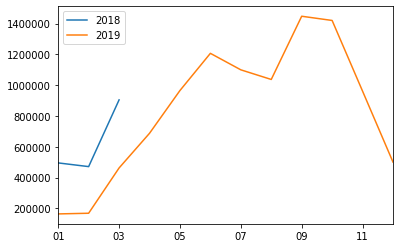

In [119]:
my.plot(kind='line')